In [10]:
import matplotlib.pyplot as plt

def dibujar_interseccion_esfera_foton(esfera, foton):
  interseccion, n = esfera.interseccion(foton)
    
  # Dibujamos la esfera
  x, y = esfera.getPlotCoords()
  plt.plot(x, y)
  plt.xlim(-2,2)
  plt.ylim(0,4)

  # Dibujar origen y vector de direccion
  plt.scatter(foton.pos[0], foton.pos[1], c='b')
  plt.quiver(foton.pos[0], foton.pos[1],
            foton.dire[0], foton.dire[1], color='b')
  if n[0] != None:
    plt.quiver(interseccion[0], interseccion[1], n[0], n[1], color='g')
  plt.axis('equal')
  

  # Dibujamos segmento de trayectoria
  plt.plot([foton.pos[0], interseccion[0]], [foton.pos[1], interseccion[1]], c='b')

  plt.scatter(interseccion[0], interseccion[1], c='r')
  # plt.scatter(interseccion_2[0], interseccion_2[1], c='r')
  plt.show()
  
def draw_fotones_hist(fotones, estructuras, expand=True):
  plt.figure(figsize=(50, 50))

  for estructura in estructuras:
    x, y = estructura.getPlotCoords()
    plt.plot(x, y)
  plt.gca().set_aspect('equal', adjustable='box')

  for foton in fotones:
    # Dibuujando camino de los fotones
    pos_hist = [p[0] for p in foton.poshist]
    x = [p[0] for p in pos_hist]
    y = [p[1] for p in pos_hist]
    plt.plot(x, y, c='b', alpha=0.05)

    # Dibujamos el vector de salida en la última posición
    if expand:
      plt.quiver(x[-1], y[-1], foton.dire[0], foton.dire[1], color='r', scale=100)  # Reduce el tamaño de las flechas
      plt.text(x[-1], y[-1], foton.n, fontsize=12, color='r')
  plt.show()


In [1]:
def generate_spheres(n, radio, x_min, x_max, y_min=50, y_max=20000, y_fixed=False):
    """
    Genera n esferas con centros (x, y, 0) tales que:
      - x está entre x_min y x_max.
      - y está entre y_min y y_max (con y_min >= 50).
      - Los centros no están tan próximos: la distancia entre dos centros >= 2 * radius.
    """
    centros = []  # Lista de centros (x, y, z)
    attempts = 0
    max_attempts = n * 1000  # Límite para evitar bucles infinitos

    while len(centros) < n and attempts < max_attempts:
        attempts += 1
        
        # Generamos coordenadas aleatorias dentro de los límites
        x = np.random.uniform(x_min, x_max)
        if y_fixed:
            y = y_min
        else:
            y = np.random.uniform(y_min, y_max)
        z = 0  # En el plano z = 0
        
        new_center = (x, y, z)
        
        # Verificamos que la nueva esfera no se solape con ninguna ya generada
        overlap = False
        for cx, cy, cz in centros:
            distance = np.linalg.norm(np.array(new_center) - np.array((cx, cy, cz)))
            if distance < 2.2 * radio:
                overlap = True
                break
        
        if not overlap:
            centros.append(new_center)

    if len(centros) < n:
        print("No se pudieron generar todas las esferas sin superposición.")
    return centros

- Medio externo n=1.4
- Capa intermedia n=1.8-2
- Políero interno n=1.4 a 1.6
- Espesor de la capa dieléctrica a 65nm

In [6]:
from materiales.SimpleMaterial import MixedComplexMaterial
from propiedades.IndicesRefraccion import nComplex
from utilidades.aleatorios import *
from entidades.estructura import Esfera, Entorno
from entidades.fuente import FuenteMonocromatica
from entidades.interfase import interactuar_interfase
from entidades.SimulatedPhoton import SimulatedPhoton
from simulacion.escenario import Escenario
from simulacion.trazador import Trazador
import numpy as np
import time

# Entorno
entorno = Entorno()


# Esferas
radio_ext = 3000
espesor = 1000
radio_int = radio_ext-espesor

n1 = nComplex(1.6, 0)
n2 = nComplex(1.456, 1e-3)
n1_capa_externa = nComplex(2, 0) # Dieléctrico
n_ext = nComplex(1.4, 0) # Agua o medio biológico
materialComplejo= MixedComplexMaterial(n=[n1,n2], fs=[0.99, 0.01])
materialComplejo_externo = MixedComplexMaterial(n=[n1_capa_externa], fs=[1])
# Fuente fotones
fuente = FuenteMonocromatica(532, 0,dispersion_pos=GenerateRandomUniformPosition2D)

d_arbitraria_ampliacion = radio_ext

n_estructuras = 10
estructuras = []
# Generamos los centros de manera que todo el diseño este
# centrado en 0, y se deje separación de 50 unidades entre
# cada esfera
# Que esten a la misma altura
multipled_spheres = False
if multipled_spheres:
  x_min = -3e5
  x_max = 3e5
  y_min = radio_ext + 2e4
  y_max = 5e4
  centros = generate_spheres(n_estructuras, radio_ext, x_min, x_max, y_min, y_max, y_fixed=True)
  print(len(centros))
  for i, centro in enumerate(centros):
    esfera = Esfera(i+1, centro, radio_ext, material_int = materialComplejo, estructura_ext=entorno)
    esfera_int = Esfera(n_estructuras+i+1, centro, radio_int, material_int = materialComplejo_externo, estructura_ext=esfera)
    estructuras.append(esfera)
    estructuras.append(esfera_int)
else:
    esfera1 = Esfera(1, np.array([0, 4000, 0]), radio_ext, material_int = materialComplejo, estructura_ext=entorno)
    esfera2 = Esfera(2, np.array([0, 4000, 0]), radio_int, material_int = materialComplejo_externo, estructura_ext=esfera1)
    estructuras = [esfera1, esfera2]
# draw_fotones_hist([], estructuras)  

# esfera1 = Esfera(1, np.array([0, 1500, 0]), radio, material_int = materialComplejo, estructura_ext=entorno)
# esfera2 = Esfera(2, np.array([0, 1500, 0]), radio/5, material_int = materialComplejo_2, estructura_ext=esfera1)
# estructuras = [esfera1, esfera2]
config_fotones = {"N_fotones":1000,
                  "mean_pos_x":0,
                  "std_pos_x":2999,
                  "mean_angle":np.pi/2,
                  "std_angle":0,
                  "reset":True}

In [8]:
import time
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

# Función auxiliar que realiza los experimentos para un valor específico de N fotones.
def process_n_fotones(n_fotones, config_fotones, n_times_experiment, estructuras, entorno, fuente, d_arbitraria_ampliacion):
    # Se crean instancias propias para evitar conflictos en paralelo
    escenario = Escenario(estructuras, entorno, fuente)
    trazador = Trazador(escenario, d_arbitraria_ampliacion)
    
    config_fotones_experiment = config_fotones.copy()
    config_fotones_experiment["N_fotones"] = n_fotones
    times = []
    abs_fractions = []
    
    for i in range(n_times_experiment):
        time_start = time.time()
        trazador.escenario.inicializar_fotones(config_fotones_experiment)
        fotones_absorbidos, fotones_inactivos, fotones = trazador.ejecutar(reset=True)
        time_end = time.time()
        
        times.append(time_end - time_start)
        abs_fractions.append(len(fotones_absorbidos) / len(fotones))
        
    return n_fotones, np.mean(times), np.mean(abs_fractions) * 100

# Parámetros experimentales
n_fotones_test = list(range(1000, 20000, 1000))
results_data = {"N fotones": [], "Time": [], "Fracción fotones absorbidos": []}
n_times_experiment = 5

# Se asume que config_fotones, estructuras, entorno, fuente y d_arbitraria_ampliacion
# ya están definidos en el contexto.

# Ejecutamos los experimentos en paralelo
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = [
        executor.submit(
            process_n_fotones, 
            n, 
            config_fotones, 
            n_times_experiment, 
            estructuras, 
            entorno, 
            fuente, 
            d_arbitraria_ampliacion
        )
        for n in n_fotones_test
    ]
    
    for future in tqdm.tqdm(as_completed(futures), total=len(futures)):
        n_fotones, avg_time, avg_abs_fraction = future.result()
        results_data["N fotones"].append(n_fotones)
        results_data["Time"].append(avg_time)
        results_data["Fracción fotones absorbidos"].append(avg_abs_fraction)



100%|██████████| 19/19 [03:36<00:00, 11.37s/it]


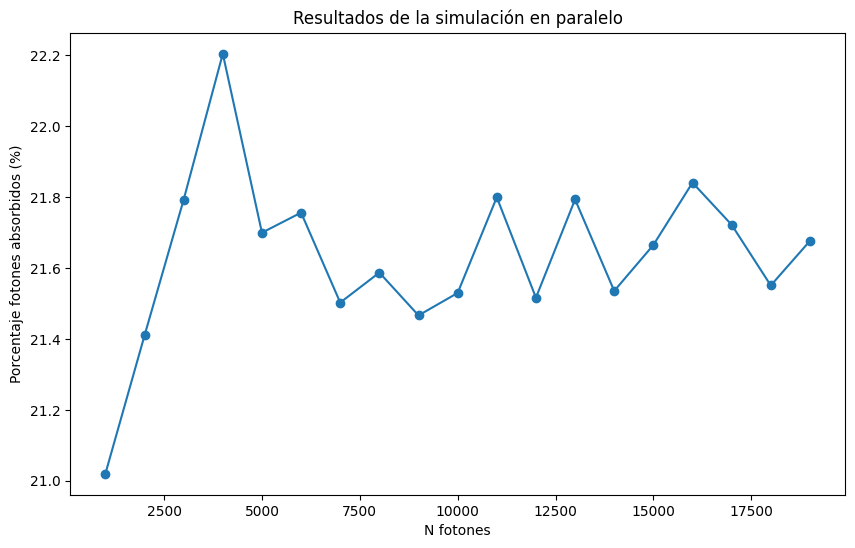

In [9]:
# Crear el DataFrame de resultados y graficar
results_df = pd.DataFrame(results_data)
results_df.sort_values(by="N fotones", inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(results_df["N fotones"], results_df["Fracción fotones absorbidos"], marker='o')
plt.xlabel("N fotones")
plt.ylabel("Porcentaje fotones absorbidos (%)")
plt.title("Resultados de la simulación en paralelo")
plt.show()


In [ ]:
import pandas as pd
import tqdm
escenario = Escenario(estructuras, entorno, fuente)
trazador = Trazador(escenario, d_arbitraria_ampliacion)

n_fotones_test = list(range(1000, 100000, 1000))
results_data = {"N fotones":[], "Time":[], "Fracción fotones absorbidos":[]}
n_times_experiment = 5
config_fotones_experiment = config_fotones.copy()
for n_fotones in tqdm.tqdm(n_fotones_test):
  config_fotones_experiment["N_fotones"] = n_fotones
  times = []
  abs_fractions = []
  for i in range(n_times_experiment):
    time_start = time.time()
    trazador.escenario.inicializar_fotones(config_fotones_experiment)
    fotones_absorbidos, fotones_inactivos, fotones = trazador.ejecutar(reset=True)
    time_end = time.time()
    times.append(time_end - time_start)
    abs_fractions.append(len(fotones_absorbidos)/len(fotones))
  results_data["N fotones"].append(n_fotones)
  results_data["Time"].append(np.mean(times))
  results_data["Fracción fotones absorbidos"].append(np.mean(abs_fractions)*100)

results_df = pd.DataFrame(results_data)
results_df.sort_values(by="N fotones", inplace=True)
plt.plot(results_df["N fotones"], results_df["Fracción fotones absorbidos"])
plt.show()

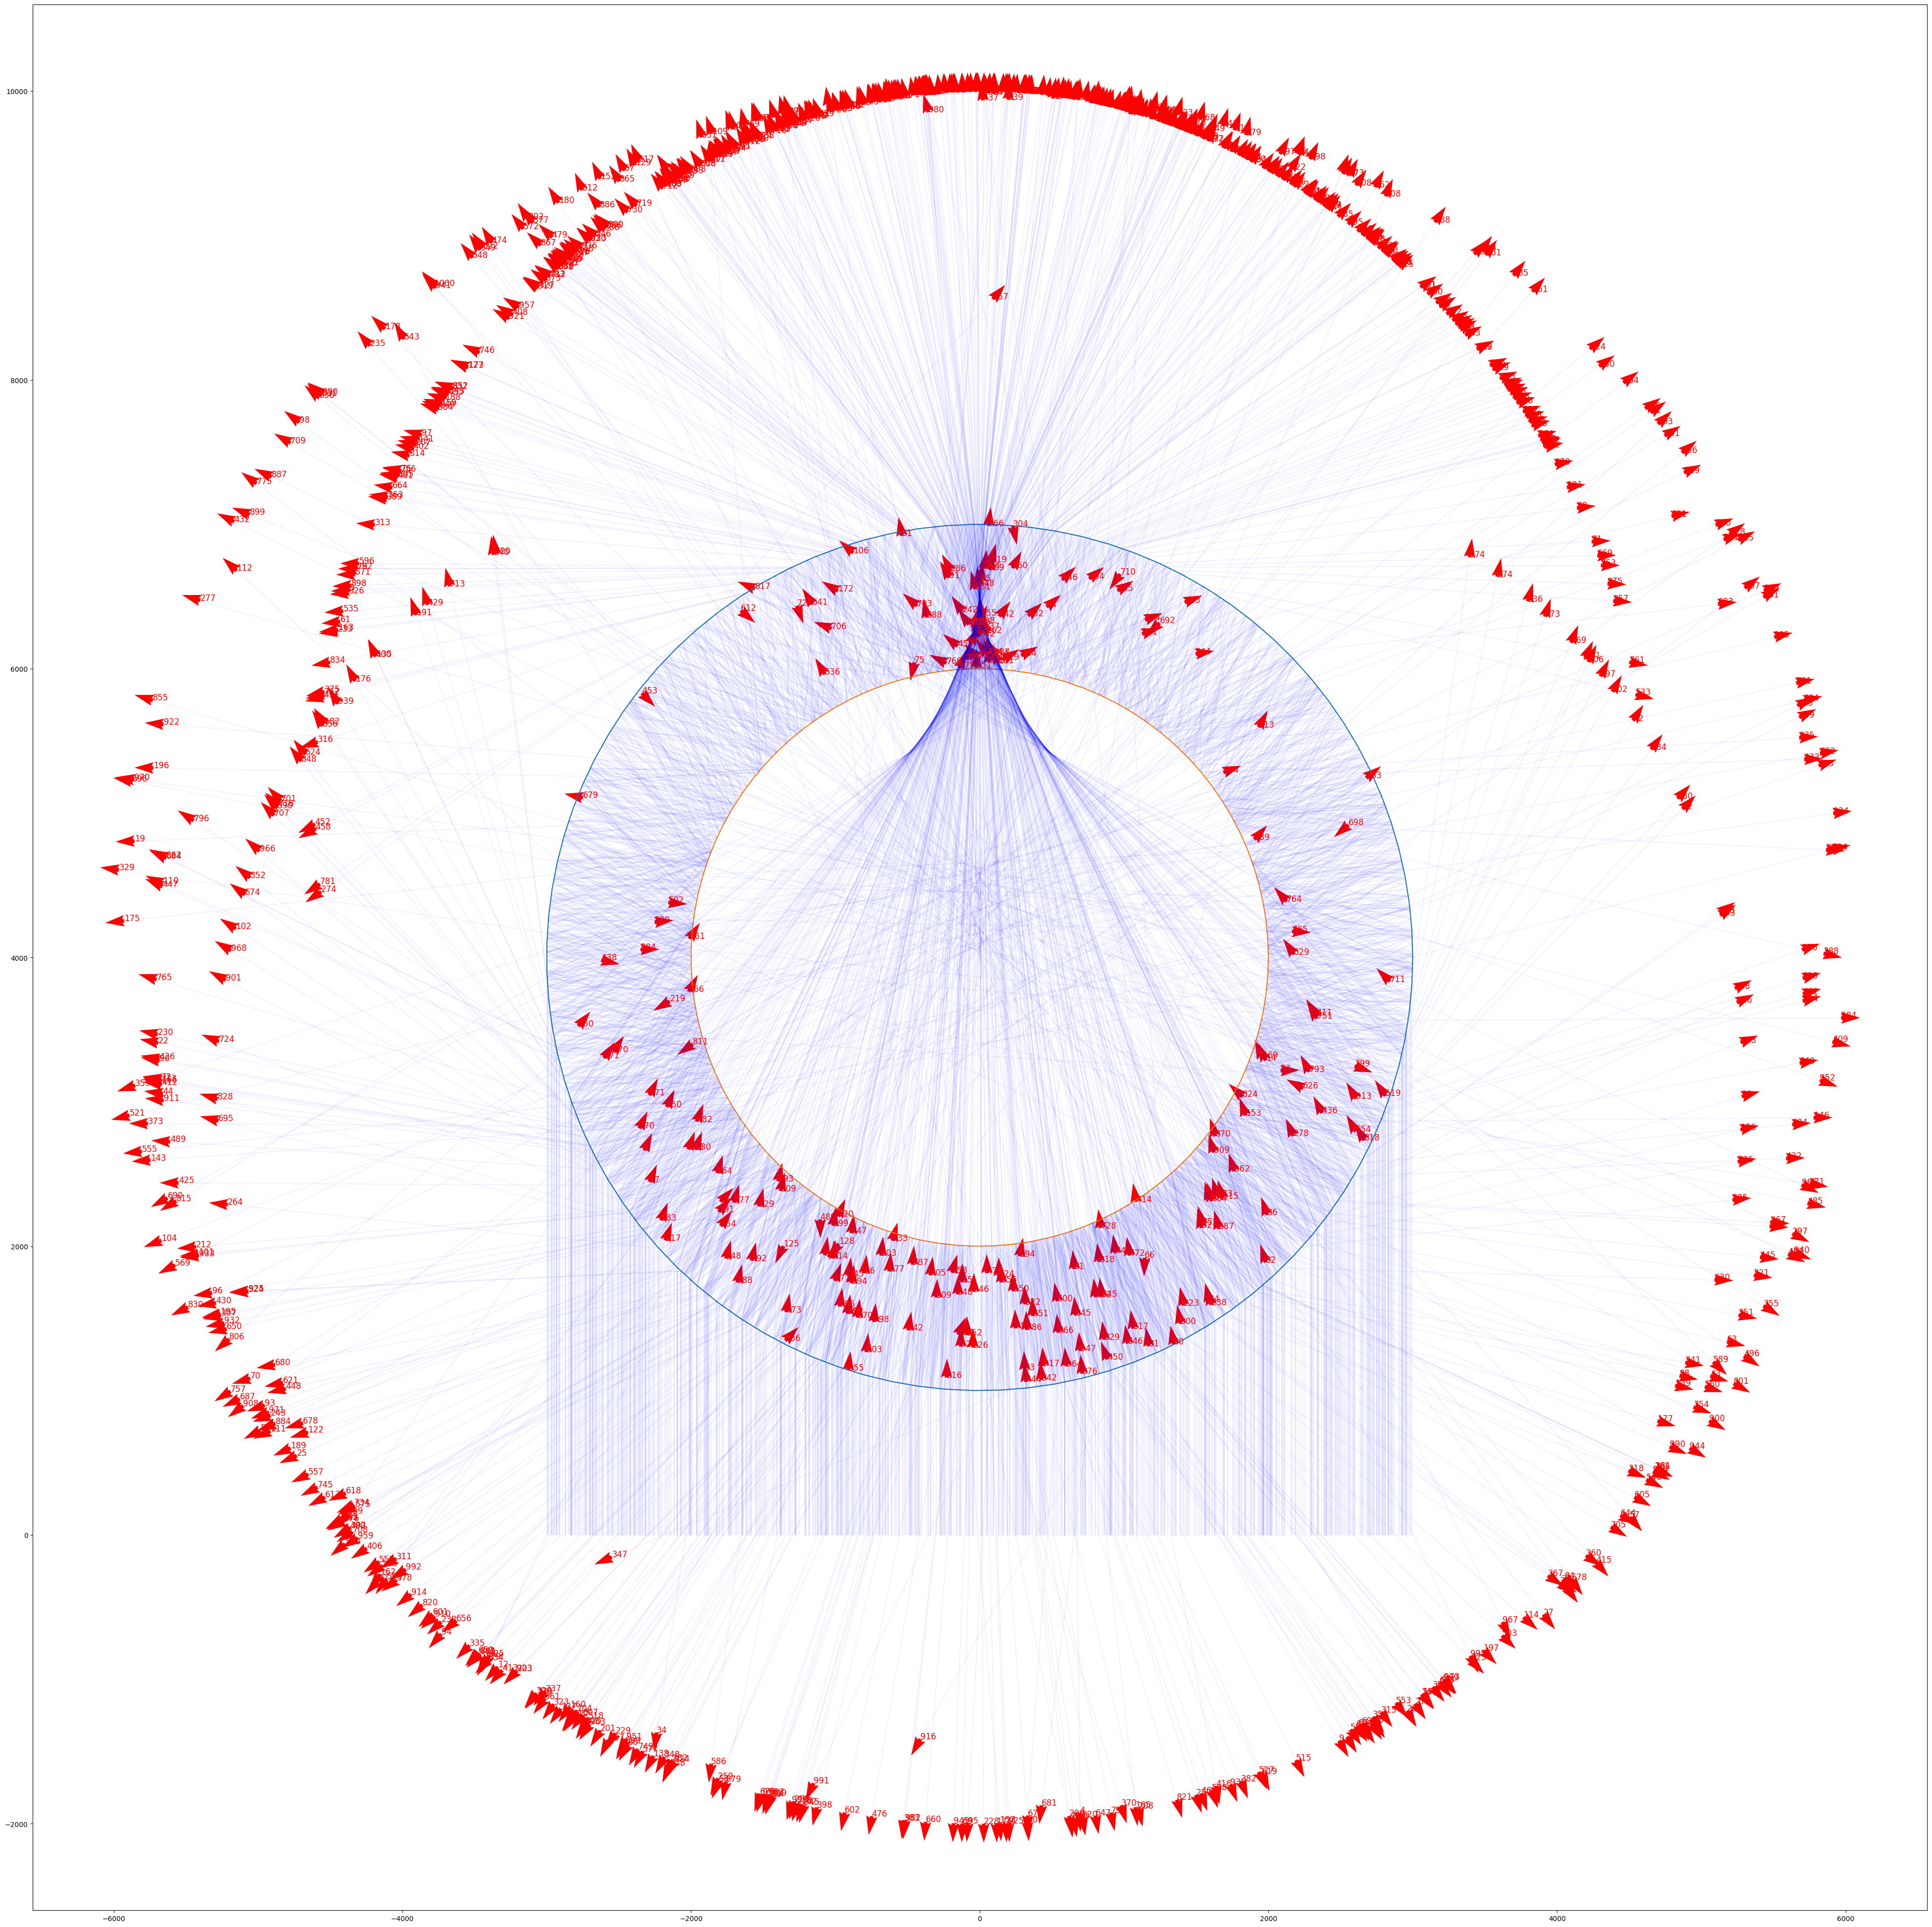

In [ ]:
escenario = Escenario(estructuras, entorno, fuente)
escenario.inicializar_fotones(config_fotonses)
trazador = Trazador(escenario, d_arbitraria_ampliacion)
trazador.escenario.inicializar_fotones(config_fotones)
fotones_absorbidos, fotones_inactivos, fotones = trazador.ejecutar(reset=True)
draw_fotones_hist(fotones_inactivos, estructuras)


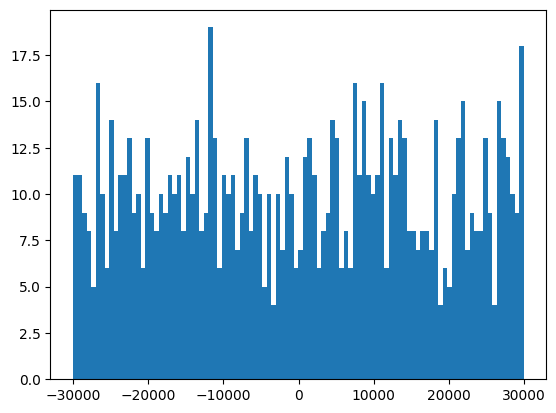

In [40]:
x_pos = []
for f in fotones:
  x_pos.append(f.poshist[0][0][0])
plt.hist(x_pos, bins=100)
plt.show()

In [ ]:
# import warnings

# warnings.filterwarnings("error")  # Convierte advertencias en excepciones

Foton fuera de la esfera
Esfera 2 con centro [1141.39615531 5136.5698287     0.        ], radio 1000 y Material con <propiedades.IndicesRefraccion.nComplex object at 0x77e6e8163790>
Esfera 2 con centro [1141.39615531 5136.5698287     0.        ], radio 1000 y Material con <propiedades.IndicesRefraccion.nComplex object at 0x77e6e8163790>
Fotón con id 2 en posición [392.90938131   0.           0.        ] y dirección [6.123234e-17 1.000000e+00 0.000000e+00]en estructura<entidades.estructura.Entorno object at 0x77e703cf8310>
N espacio foton  1
N espacio transmitido  1.5986242053716067


Foton dentro de la esfera
Esfera 2 con centro [1141.39615531 5136.5698287     0.        ], radio 1000 y Material con <propiedades.IndicesRefraccion.nComplex object at 0x77e6e8163790>
Fotón con id 2 en posición [ 392.90938131 4473.4201102     0.        ] y dirección [0.35088583 0.93641825 0.        ]en estructuraEsfera 2 con centro [1141.39615531 5136.5698287     0.        ], radio 1000 y Material con <prop

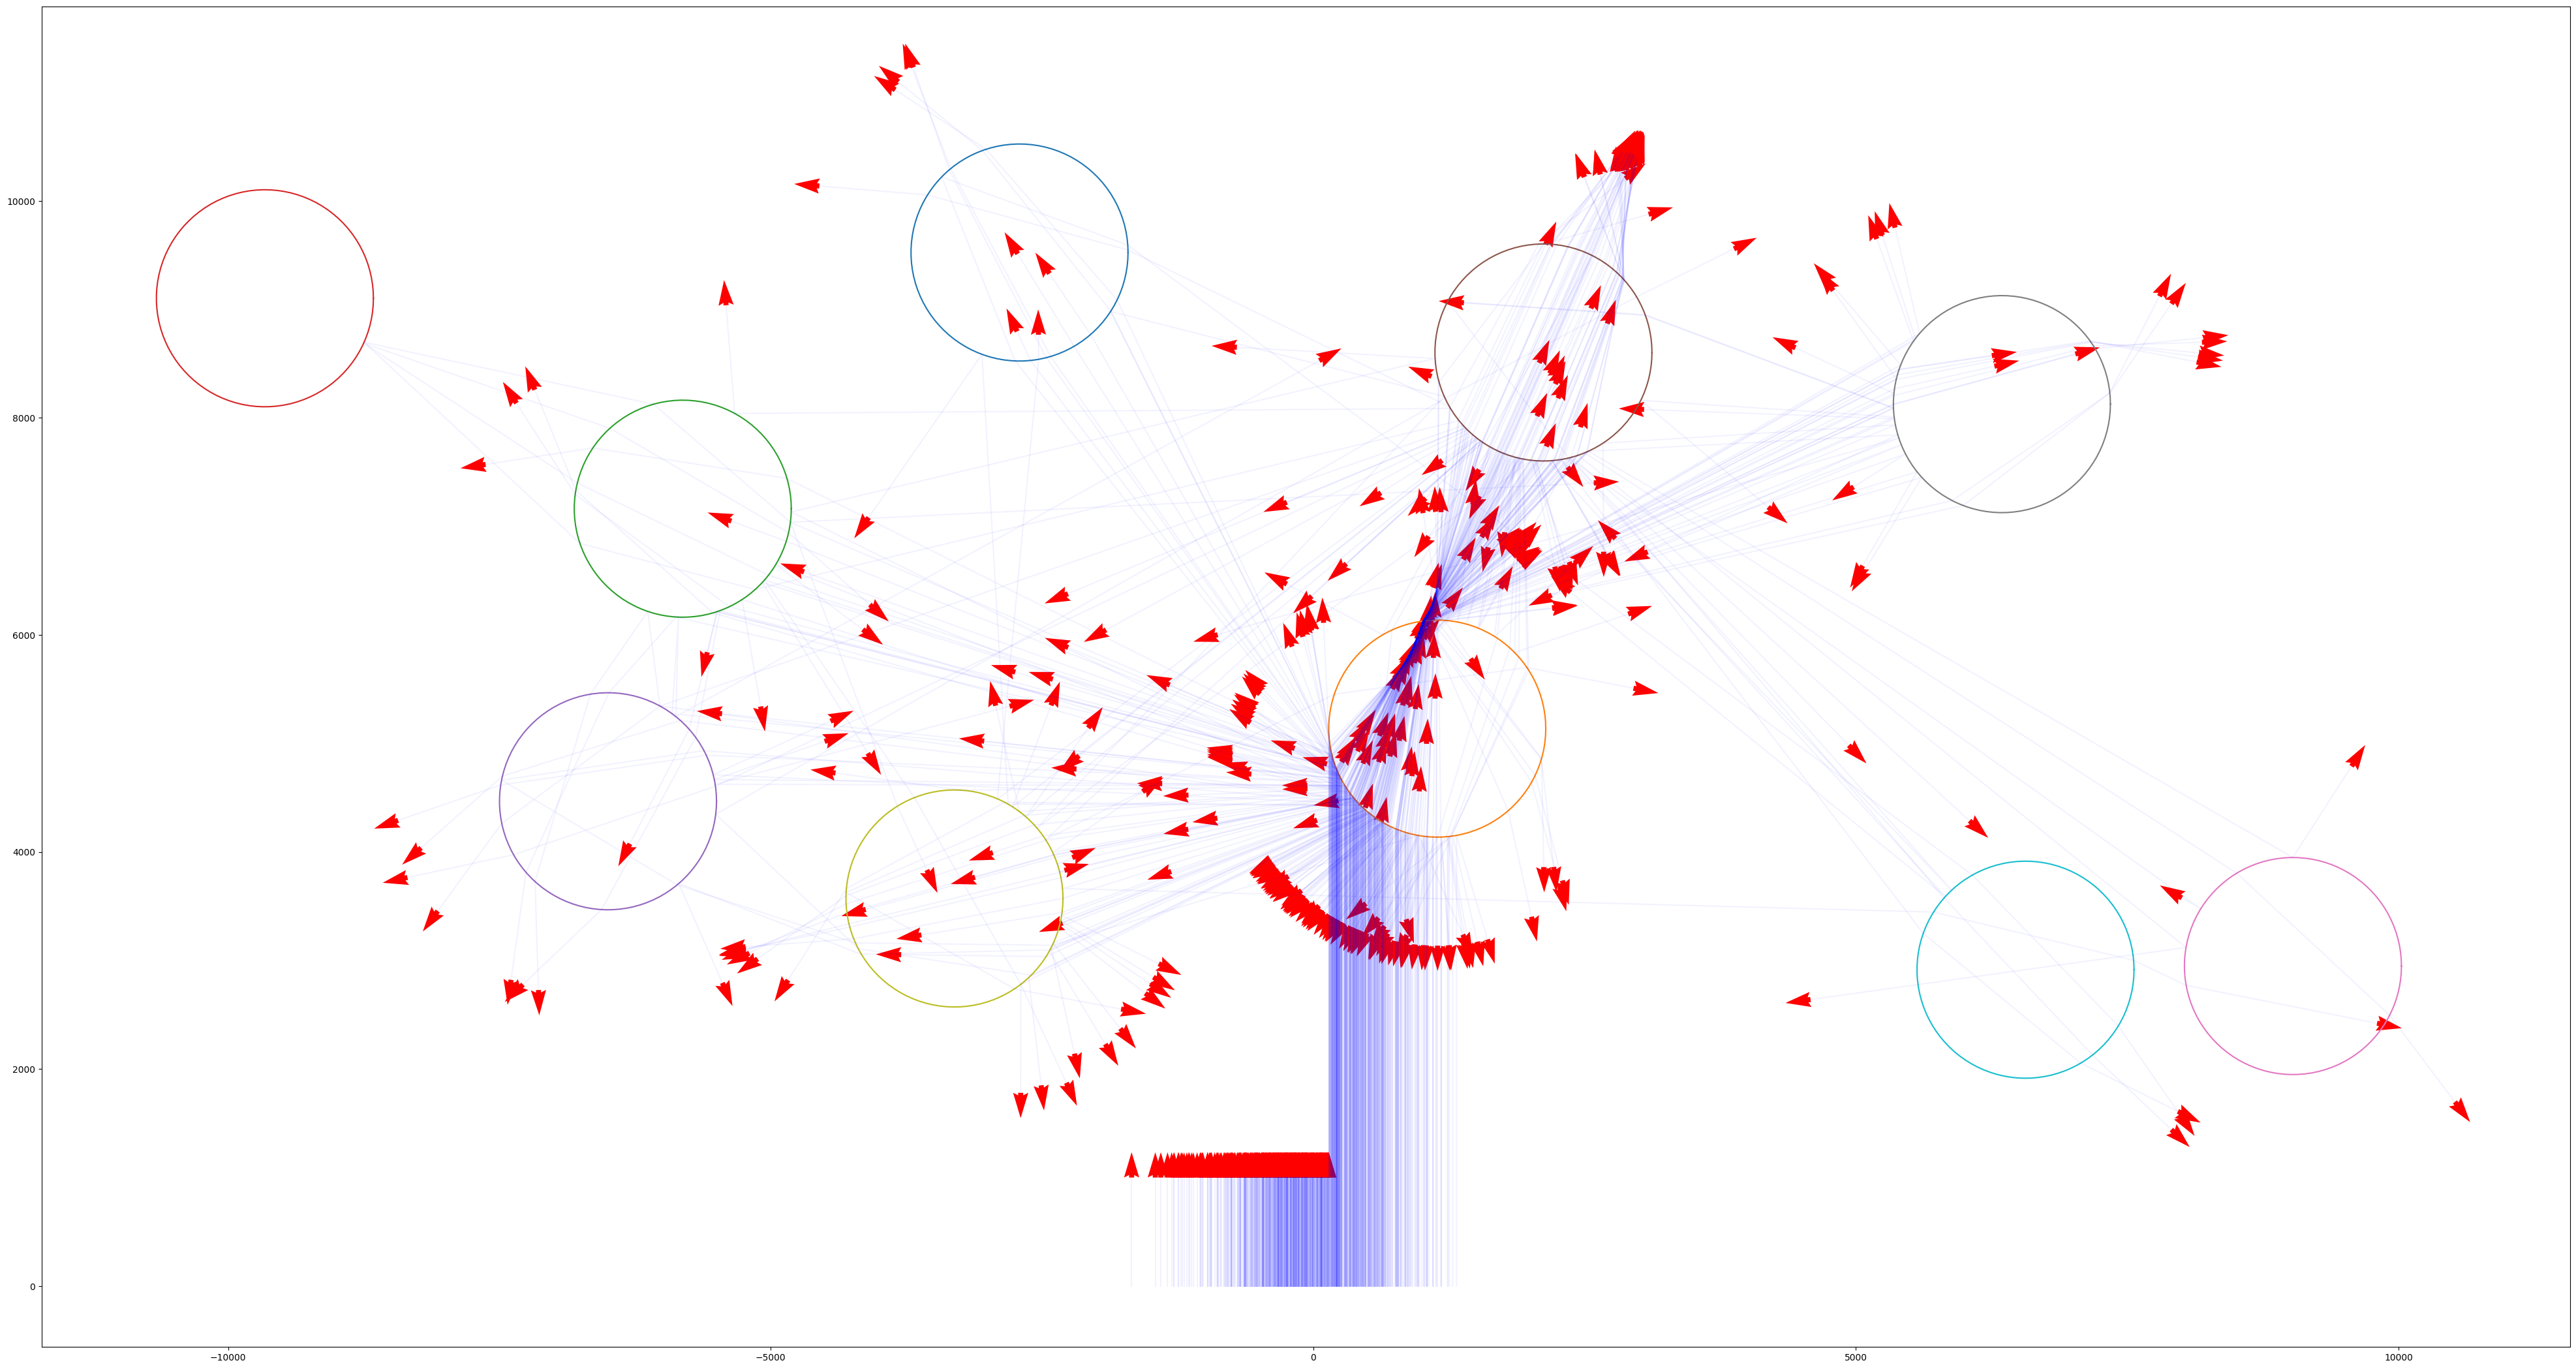

Fotones absorbidos:  136
Fotones total:  1000


In [6]:
import time

fotones = fuente.emitirN(1000, 0, 500, std_ang=0)
# fotones_activos = []
fotones_inactivos = []
fotones_absorbidos = []
error_foton = []
time_start = time.time()
# Fotones absorbidos
n_abs = 0
# alfa = materialComplejo.alfa(fotones[0].lamda)

for f in fotones:
  # Esta lógica hay que cambiarla
  while True:
    
    min_pint, min_n = [None, None, None], None
    estructura_interaccion = None
    for i, estructura in enumerate(estructuras):
        # print("\n")
        # print(f)
        p_int, n = estructura.interseccion(f)
        if p_int[0]==None:
          continue
        
        if min_pint[0] == None:
          min_pint = p_int
          min_n = n
          estructura_interaccion = estructura
        else:
          if np.linalg.norm(f.pos - p_int) < np.linalg.norm(f.pos - min_pint):
            min_pint = p_int
            min_n = n
            estructura_interaccion = estructura
            
            
    if min_pint[0] == None:
      f.actualizarPos(f.pos+f.dire*d_arbitraria_ampliacion)
      fotones_inactivos.append(f)
      break
    
    # Comprobamos si se absorbe antes de interaccionar con una interfase
    l_pos = np.linalg.norm(min_pint-f.pos)
    alfa = f.estructura.material_int.alfa(f.lamda)
    absorbido, labs = probAbs(l_pos, alfa)
    if absorbido:
      # print("\n")
      # print("Fotón no absborbido")
      # print("Estado final ", f)
      n_abs += 1
      f.actualizarPos(f.pos + f.dire*labs)
      fotones_inactivos.append(f)
      fotones_absorbidos.append(f)
      break
    
    # Si no es absorbido, calculamos la interacción con la interfase
    try:
      if f.estructura != estructura_interaccion:
        print("Foton fuera de la esfera")
        estructura_foton = estructura_interaccion.estructura_ext
        print(estructura.estructura_ext)
        estructura_transmitida = estructura_interaccion
        print(estructura_transmitida)
      else:
        print("Foton dentro de la esfera")
        
        estructura_foton = estructura_interaccion
        estructura_transmitida = estructura_interaccion.estructura_ext
      
      n_foton = estructura_foton.material_int.indice_refraccion.calcular(f.lamda)
      n_trans = estructura_transmitida.material_int.indice_refraccion.calcular(f.lamda)
      print(estructura_interaccion)
      print(f)
      print("N espacio foton ", n_foton)
      print("N espacio transmitido ", n_trans)
      print("\n")
      new_dire, result = interactuar_interfase(min_n, f, n_foton=n_foton, n_t = n_trans)
    except Exception as e:
      print(e)
      print(min_pint)
      error_foton.append(f)
      raise Exception("Error")
    
    # Si se refleja cambiamos su posición y dirección
    if result == "reflect":
      # print("Fotón reflejado en la interfase")
      # print("Actualizando posición a ", p_int)
      f.actualizarPos(min_pint)
      f.actualizarDire(new_dire)
      continue
    
    # Si se refracta cambiamos su posición, dirección y espacio en el que está
    if result == "refract":
      # print("Fotón refractado en la interfase")
      # print("Actualizando posición a ", p_int)
      f.actualizarPos(min_pint)
      f.actualizarDire(new_dire)
      f.estructura = estructura_transmitida
      continue
      
time_end = time.time()
print("Tiempo de ejecución: ", time_end - time_start)
draw_fotones_hist(fotones_inactivos, estructuras)
print("Fotones absorbidos: ", n_abs)
print("Fotones total: ", len(fotones))

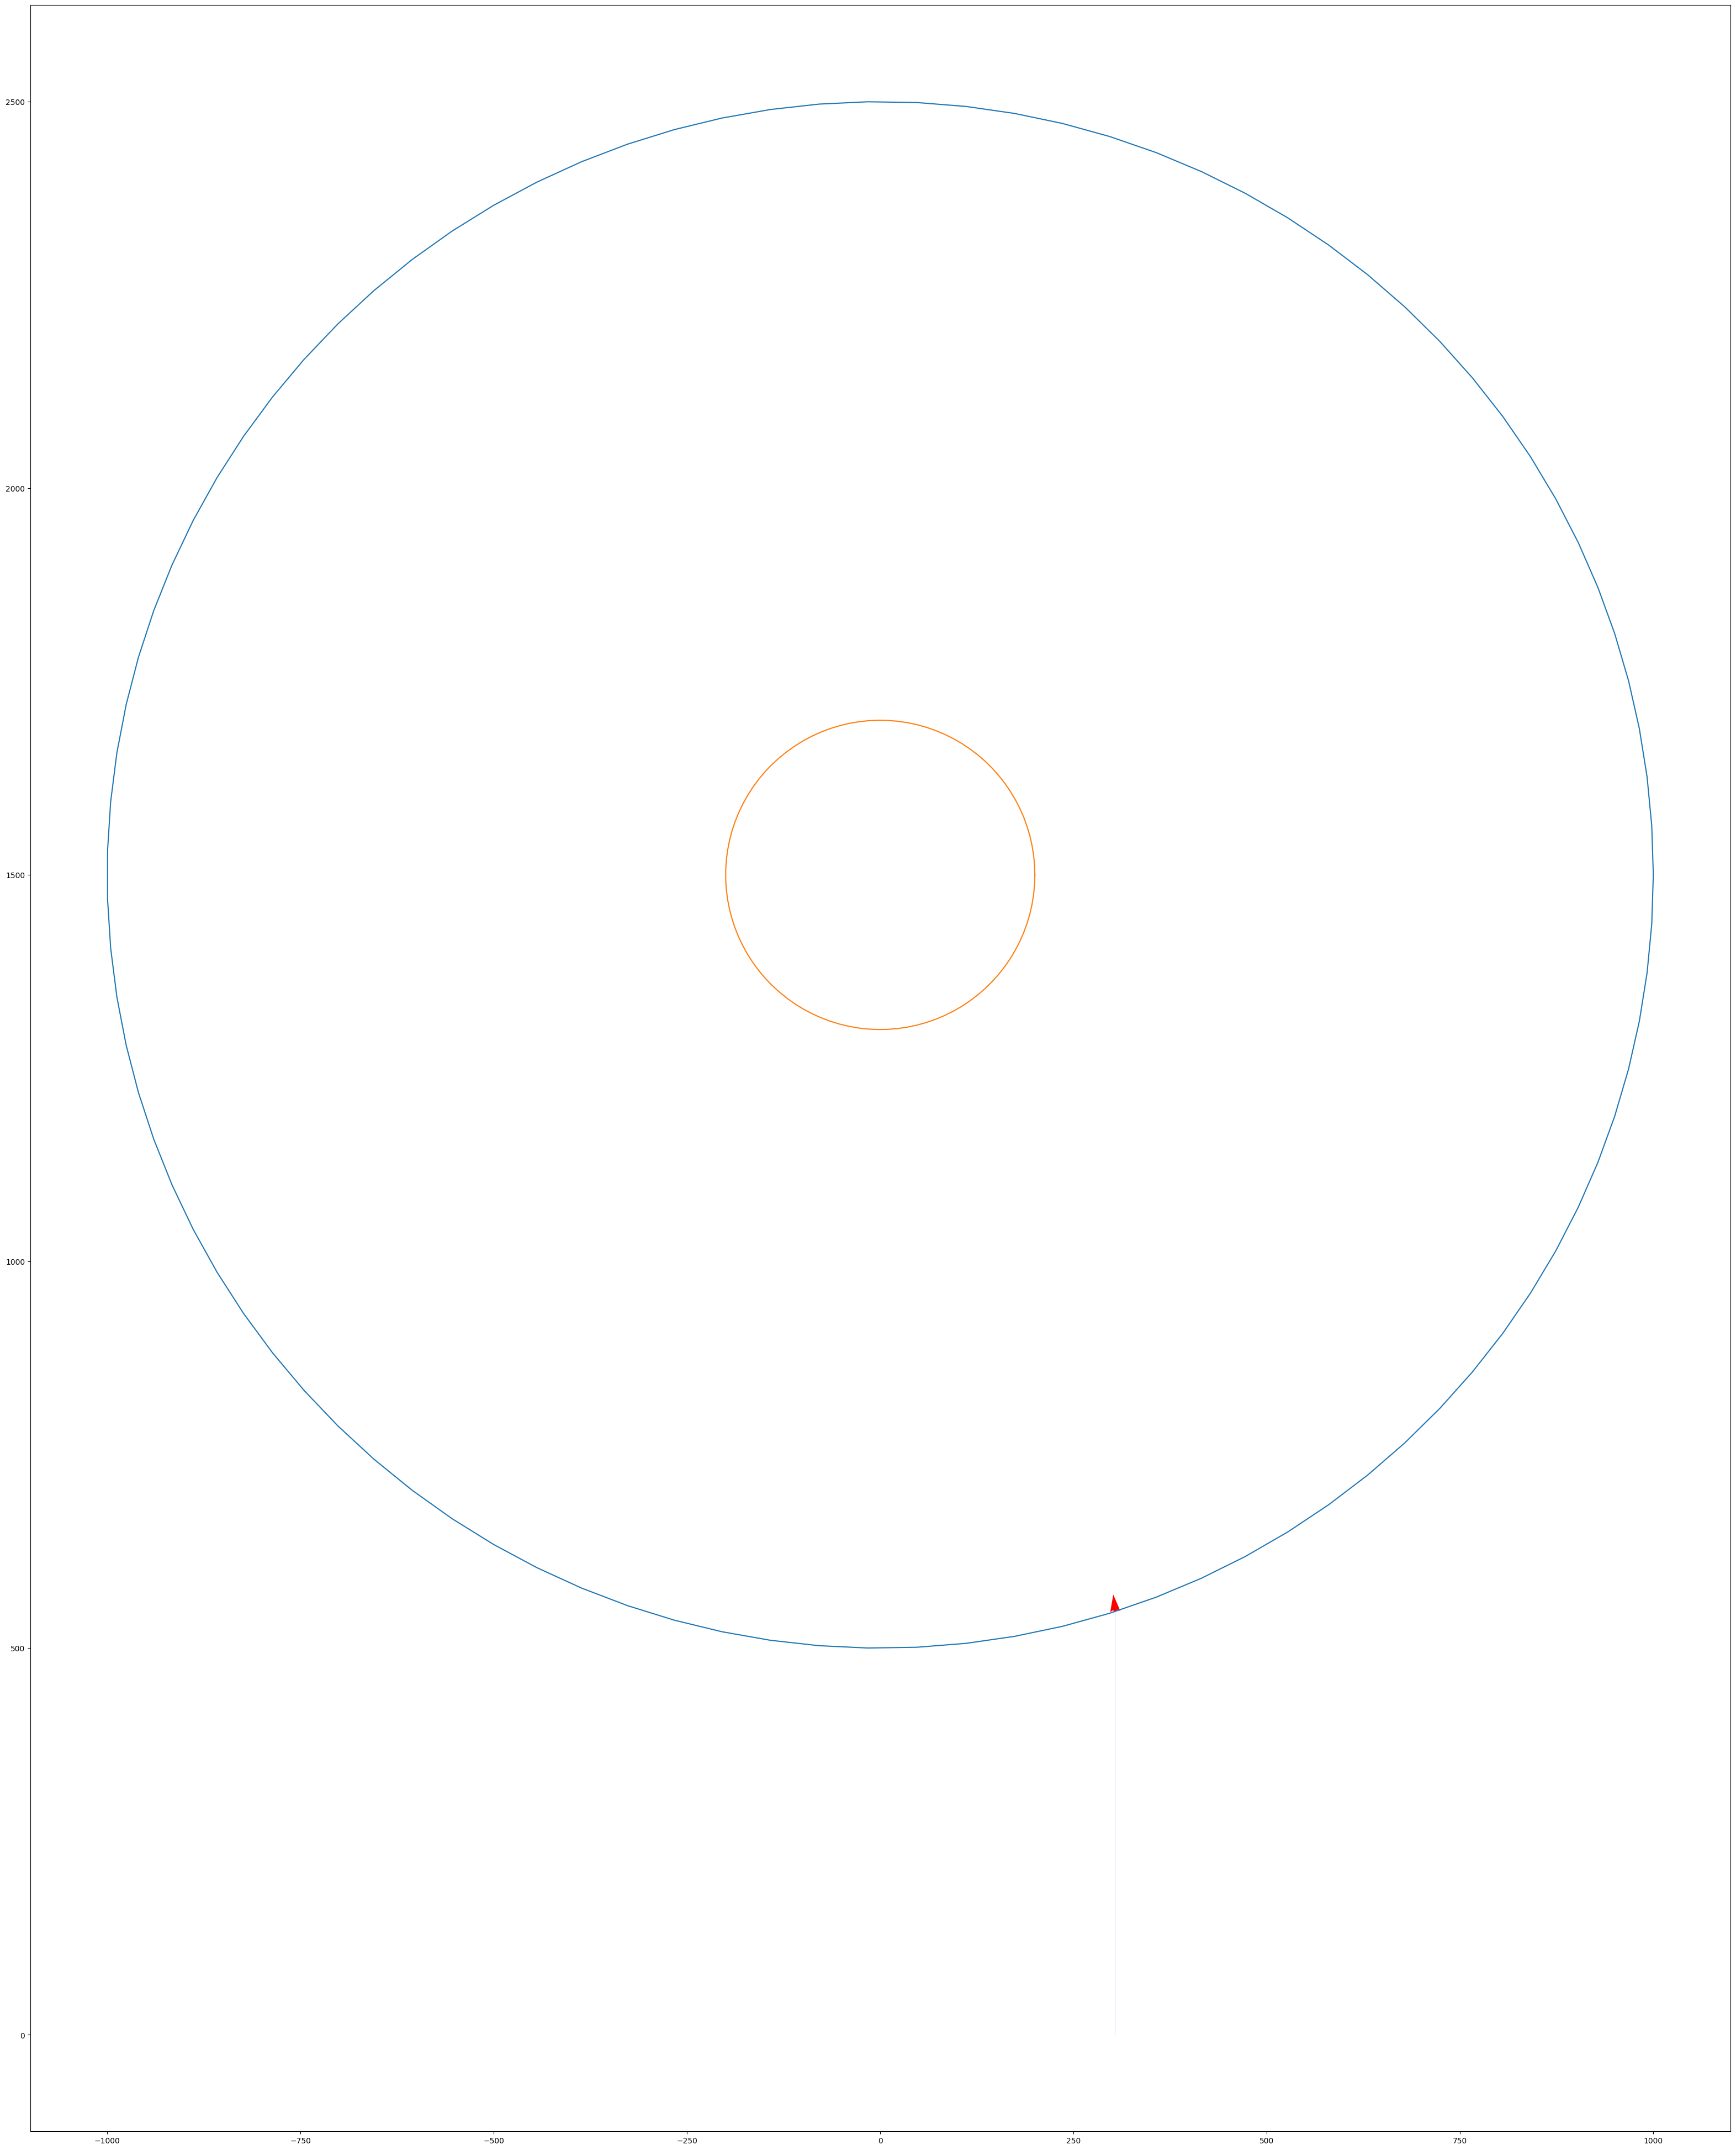

In [8]:
draw_fotones_hist(error_foton, estructuras)

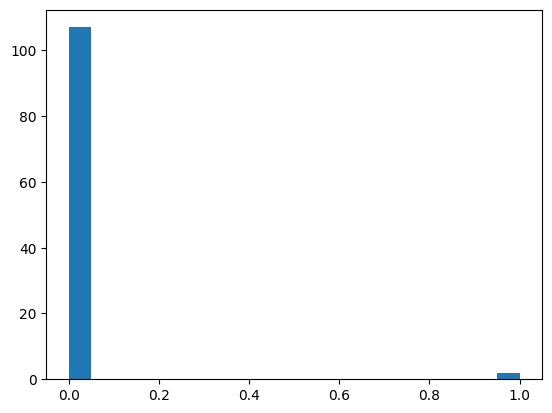

In [ ]:
rebotes = []
for f in fotones_absorbidos:
  rebotes.append(f.getNumeroReflexiones())
plt.hist(rebotes, bins=20)
plt.show()